In [1]:
## Backend library imports
import numpy as np
import os
import sys
import time
import torch
import scipy
from scipy.signal import butter, filtfilt
from sklearn.decomposition import NMF

## Plotting library imports
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import fastplotlib as fpl

## Demixing imports
import localnmf 
import masknmf
from masknmf.visualization import make_demixing_video

%load_ext autoreload
%load_ext line_profiler

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01,\x00\x00\x007\x08\x06\x00\x00\x00\xb6\x1bw\x99\x…

No windowing system present. Using surfaceless platform
No config found!
No config found!


Available devices:
✅ (default) | NVIDIA TITAN RTX | DiscreteGPU | Vulkan | 545.23.08
❗ | llvmpipe (LLVM 12.0.0, 256 bits) | CPU | Vulkan | Mesa 21.2.6 (LLVM 12.0.0)
❗ | NVIDIA TITAN RTX/PCIe/SSE2 | Unknown | OpenGL | 


# Decide which device the demixing is run on, cuda or cpu

In [2]:
device='cuda'

# Load the high-pass filtered PMD data, convert it to a rlocalnmf Signal Demixer object

In [3]:
# filename = "High_Pass_PMD_Decomposition.npz"
filename = "Decomposition_File_High_Pass_5_50_450_50_275.npz"
full_pmd_movie = np.load(filename, allow_pickle=True)['pmd'].item()

In [4]:
#Construct the SignalDemixer demixing object
num_frames, fov_dim1, fov_dim2 = full_pmd_movie.shape
highpass_pmd_demixer = localnmf.SignalDemixer(full_pmd_movie.U_sparse,
                                                full_pmd_movie.R,
                                                full_pmd_movie.s,
                                                full_pmd_movie.V,
                                                (fov_dim1, fov_dim2, num_frames), 
                                                data_order=full_pmd_movie.order,
                                                device=device)

# Run 1st pass demixing on this data

# Identify remaining signals here

Computing correlation data structure with MAD threshold  2and the robust corr term is 0.03
find superpixels!
find pure superpixels!
prepare iteration!


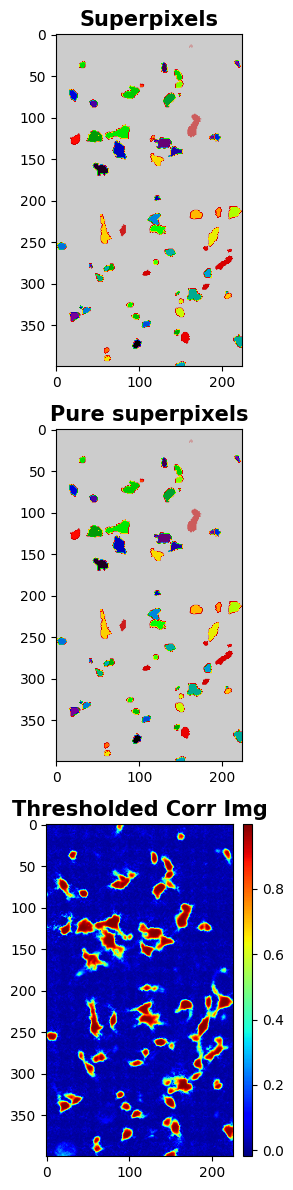

In [5]:
init_kwargs = {
    #Worth modifying
    'mad_correlation_threshold':0.9,
    'min_superpixel_size':5,

    #Mostly stable
    'mad_threshold':2,
    'residual_threshold': 0.3,
    'patch_size':(40, 40),
    'robust_corr_term':0.03,
    'plot_en':True,
    'text':False,
}

highpass_pmd_demixer.initialize_signals(**init_kwargs, is_custom = False)

# Lock the above results and move to demixing

In [6]:
highpass_pmd_demixer.lock_results_and_continue()

Now in demixing state


# Demix the data

In [7]:
## Now run demixing...
localnmf_params = {
    'maxiter':25,
    'support_threshold':np.linspace(0.7, 0.6, 25).tolist(),
    'deletion_threshold':0.2,
    'ring_model_start_pt':30, #No ring model needed
    'ring_radius':5,
    'merge_threshold':0.8,
    'merge_overlap_threshold':0.8,
    'update_frequency':4,
    'c_nonneg':False,
    'denoise':False,
    'plot_en': False
}

start_time = time.time()
with torch.no_grad():
    highpass_pmd_demixer.demix(**localnmf_params)
print(f"that took {time.time() - start_time}")




100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 25.35it/s]


that took 1.294919729232788


# Visualize a demixing video. Things to check: are there missing neural signals in the demixing video? This is fine -- you can run a second pass of demixing on the "residual" to identify those signals. 

In [24]:
results = highpass_pmd_demixer.results

iw = make_demixing_video(results,
                    device,
                    v_range=[-1, 1])

iw.show()

# Lock these results in and continue

In [10]:
highpass_pmd_demixer.lock_results_and_continue()

Now in the initialization state


# [Optional]: Multipass -- if you think there are residual signals, you can run initialization again followed by demixing. This multi-pass approach combines the previous results with the new initializations and uses this "superset" of signals to seed the new round of demixing. Only run the below if you believe there are missing signals based on the above. 

Computing correlation data structure with MAD threshold  2and the robust corr term is 0.03
find superpixels!
find pure superpixels!
prepare iteration!


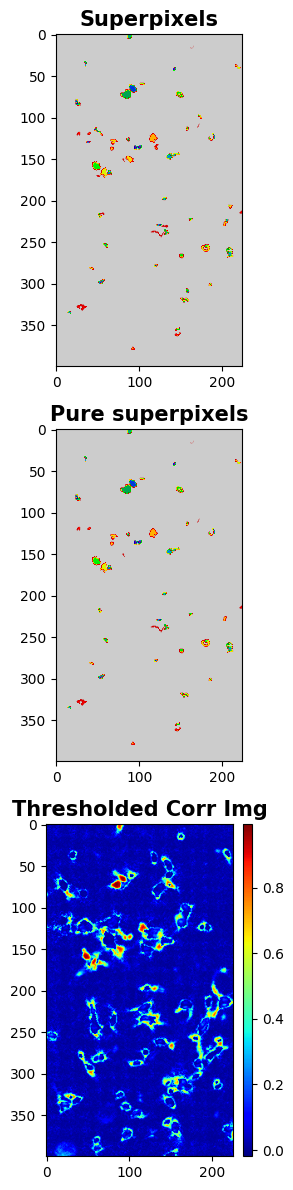

In [11]:
init_kwargs = {
    #In the second pass, these params are smaller to pick up "smaller" signals
    'mad_correlation_threshold':0.8,
    'min_superpixel_size':5,

    #Mostly stable
    'mad_threshold':2,
    'residual_threshold': 0.3,
    'patch_size':(40, 40),
    'robust_corr_term':0.03,
    'plot_en':True,
    'text':False,
}

highpass_pmd_demixer.initialize_signals(**init_kwargs, is_custom = False)

# [Optional]: Lock the above results and move to demixing

In [12]:
highpass_pmd_demixer.lock_results_and_continue()

Now in demixing state


# [Optional]: Run demixing

In [13]:
## Now run demixing...
localnmf_params = {
    'maxiter':25,
    'support_threshold':np.linspace(0.7, 0.4, 25).tolist(),
    'deletion_threshold':0.2,
    'ring_model_start_pt':30, #No ring model needed
    'ring_radius':5,
    'merge_threshold':0.8,
    'merge_overlap_threshold':0.8,
    'update_frequency':4,
    'c_nonneg':True,
    'denoise':False,
    'plot_en': False
}

start_time = time.time()
with torch.no_grad():
    highpass_pmd_demixer.demix(**localnmf_params)
print(f"that took {time.time() - start_time}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 19.68it/s]

that took 1.591900110244751


In [23]:
results = highpass_pmd_demixer.results

iw = make_demixing_video(results,
                         device,
                         v_range=[-1, 1])

iw.show()

# Part 2: Take the above spatial signals, and regress the (unfiltered) PMD data onto it. Note: the "support expansion", merging, are all disabled here (we do all that on the filtered data). At this stage we can just do alternating least squares updates to estimate A and C.

# Load the (unfiltered) PMD data and regress it directly onto the above spatial profiles

In [16]:
filename = "Decomposition_File_50_450_50_275.npz"
full_pmd_movie = np.load(filename, allow_pickle=True)['pmd'].item()

In [17]:
#Construct the SignalDemixer demixing object
num_frames, fov_dim1, fov_dim2 = full_pmd_movie.shape
unfiltered_pmd_demixer = localnmf.SignalDemixer(full_pmd_movie.U_sparse,
                                                full_pmd_movie.R,
                                                full_pmd_movie.s,
                                                full_pmd_movie.V,
                                                (fov_dim1, fov_dim2, num_frames), 
                                                data_order=full_pmd_movie.order,
                                                device=device)

# Initialize the signals using the "custom" option, where we provide pre-computed spatial footprints

In [18]:
unfiltered_pmd_demixer.initialize_signals(is_custom=True, a=highpass_pmd_demixer.results.a)
unfiltered_pmd_demixer.lock_results_and_continue()

Now in demixing state


# Run demixing, with no support updates

In [19]:
## Now run demixing...
localnmf_params = {
    'maxiter':25,
    'support_threshold':np.linspace(0.7, 0.6, 25).tolist(),
    'deletion_threshold':0.2,
    'ring_model_start_pt':35, #No ring model needed
    'ring_radius':5,
    'merge_threshold':0.8,
    'merge_overlap_threshold':0.8,
    'update_frequency':40, #No support updates
    'c_nonneg':False,
    'denoise':False,
    'plot_en': False
}

start_time = time.time()
with torch.no_grad():
    unfiltered_pmd_demixer.demix(**localnmf_params)
print(f"that took {time.time() - start_time}")




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 131.97it/s]


that took 0.5136072635650635


# Step 3: Visualize + export results

# Visualize final demixing results as a demixing video

In [22]:
results = unfiltered_pmd_demixer.results

iw = make_demixing_video(results,
                         device,
                         v_range=[-5, 5])

iw.show()

# Plot the results into a folder

In [58]:
results = unfiltered_pmd_demixer.results
for i in range(results.a.shape[1]):
    name = f"neuron_{i}.png"
    analyze_neuron_i(i, results, folder="data_folder", name=name)